In [ ]:
import pandas as pd
import numpy as np
from itertools import permutations
from sklearn import preprocessing
from functools import reduce
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn import preprocessing
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.cluster import AgglomerativeClustering
warnings.simplefilter("ignore")
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

## 1. Recommendation sytem
Implementing a recommendation system is critical for businesses and digital platforms that want to thrive in today's competitive environment. These systems use data-driven personalization to tailor content, products, and services to individual user preferences. The latter improves user engagement, satisfaction, retention, and revenue through increased sales and cross-selling opportunities. In this section, you will attempt to implement a recommendation system by identifying similar users' preferences and recommending movies they watch to the study user.

To be more specific, you will implement your version of the [**LSH algorithm**](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input the user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user.

__Data__: The data you will be working with can be found [here](https://www.kaggle.com/datasets/vodclickstream/netflix-audience-behaviour-uk-movies).

Looking at the data, you can see that there is data available for each user for the movies the user <ins>clicked on</ins>. Gather the __title and genre__ of the __maximum top 10 movies__ that each user clicked on regarding the __number of clicks__.

---


### Pre-processing the data frame

Firstly, let's import the data. We can observe that the dataset is in CSV format, making it straightforward to import.

In [ ]:
# Save the csv file in a variable to work on it
df = pd.read_csv("./uk_movies_03.csv")

We can use .info() to obtain a concise summary of information about the DataFrame.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


We have a dataset with 7 columns, where each one of the 671 736 row corresponds to a user click on a specific movie. The users are identified by the `user_id` column, and each click is associated with a particular film denoted by the `movie_id` column.

We can also notice that there no null values. Now let's see if there are duplicates among the entries.

In [ ]:
# analyze if there are duplicates
sum(df.duplicated())

0

All the rows are unique, so we don't need to do other manipulations on the dataframe.

### EXERCISE 1.1

Let's proceed by retrieving the titles and genres of the top 10 movies that each user clicked on, based on the number of clicks.

The approach involves grouping the dataframe by both `user_id` and `movie_id` and counting the occurrences of the same `movie_id` for each user. This new info will be stored in the `clicks` column.

In [ ]:
# group the df by user_id and movie_id and create another column clicks
movie_counts = df.groupby(['user_id', 'movie_id']).size().reset_index(name='clicks')
# sort the df by clicks for every user
df_sorted = movie_counts.sort_values(by=['user_id', 'clicks'], ascending=[True, False])
# let's consider only the first 10 films for each user
top_10_movies_per_user = df_sorted.groupby('user_id').head(10)
top_10_movies_per_user

,user_id,movie_id,clicks
0,00004e2862,9bfee795ff,1
2,000052a0a0,4718f9963c,9
3,000052a0a0,4fa0b092d6,3
6,000052a0a0,7314699c23,3
5,000052a0a0,6275614f9a,2
...,...,...,...
502501,fffeac83be,a2d8a56924,1
502503,fffeac83be,dda0eae17b,1
502504,ffff2c5f9e,6467fee6b6,1
502505,ffff2c5f9e,9ab62a3f2c,1


This new dataframe currently contains only the movie IDs and it lacks the information about movie titles and genres. To enrich this information, we can merge it with the original dataframe.

In [ ]:
# get the title and the genres for each movie_id
res = pd.merge(top_10_movies_per_user[['user_id', 'movie_id', 'clicks']],
            df[['movie_id', 'title', 'genres', 'user_id']], on=['movie_id', 'user_id'], how = "left")

# drop duplicates generated during the merge operation
res.drop_duplicates()

,user_id,movie_id,clicks,title,genres
0,00004e2862,9bfee795ff,1,Hannibal,"Crime, Drama, Thriller"
1,000052a0a0,4718f9963c,9,Looper,"Action, Drama, Sci-Fi, Thriller"
10,000052a0a0,4fa0b092d6,3,Jumanji,"Adventure, Comedy, Family, Fantasy"
13,000052a0a0,7314699c23,3,Frailty,"Crime, Drama, Thriller"
16,000052a0a0,6275614f9a,2,Resident Evil,"Action, Horror, Sci-Fi"
...,...,...,...,...,...
613389,fffeac83be,a2d8a56924,1,Son of Saul,"Drama, War"
613390,fffeac83be,dda0eae17b,1,Enemy at the Gates,"Drama, History, War"
613391,ffff2c5f9e,6467fee6b6,1,Hot Fuzz,"Action, Comedy, Mystery, Thriller"
613392,ffff2c5f9e,9ab62a3f2c,1,Forks Over Knives,Documentary


If we want to get the top 10 movies clicked in general by all the users, not the top 10 for every user, we can use the following code, which is implemented in a manner similar to the previous approach.

In [ ]:
grouped_df = df.groupby(['title', 'genres']).size().reset_index(name='clicks').reset_index(drop=True)
grouped_df = grouped_df.sort_values(by='clicks',ascending=False)
grouped_df.head(10)

,title,genres,clicks
1035,Black Mirror: Bandersnatch,"Drama, Mystery, Sci-Fi, Thriller",6436
1207,Bright,"Action, Fantasy, Thriller",3110
705,Avengers: Age of Ultron,"Action, Adventure, Sci-Fi",2898
589,Annihilation,"Adventure, Drama, Horror, Mystery, Sci-Fi, Thr...",2699
2967,Hot Fuzz,"Action, Comedy, Mystery, Thriller",2674
1761,Deadpool,"Action, Adventure, Comedy, Sci-Fi",2576
1018,Bird Box,"Drama, Horror, Sci-Fi",2549
2221,FYRE: The Greatest Party That Never Happened,"Documentary, Music",2332
6399,The Big Short,"Biography, Comedy, Drama, History",2204
6826,The Hitman's Bodyguard,"Action, Comedy, Crime, Thriller",2179


### 1.2 Minhash Signatures
Using the movie `genre` and `user_ids`, try to implement your min-hash signatures so that users with similar interests in a genre appear in the same bucket.

__Important note:__ You must write your minhash function from scratch.  You are not permitted to use any already implemented hash functions.  Read the class materials and, if necessary, conduct an internet search.  The description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf) may be helpful as a reference.

---

We need to implement the _MinHash function_, to estimate the similarity between an input user and all the others, in order to detect similar users and recommend films that could like.

In this initial phase of our implementation of it, we aim to create MinHash signatures for users based on their genre preferences and subsequently organize them into different buckets to group users with similar genre interests.

The key steps for implementing the MinHash function can be summarized as follows:

1. **Shingle Matrix**: in this initial step, we'll construct the shingle matrix by utilizing the genres observed by users. The shingle matrix will have unique genres as columns and user IDs as row indexes. For each entry in the matrix, a value of 1 will indicate that the user has viewed a film associated with that particular genre, we will put a 0 otherwise.

In [ ]:
# Let's get the list of the unique genres
genres = df["genres"].to_frame() # extract the 'genres' column

uni = [] # list where we will put the genres

for i in range(len(genres)):
    x=genres["genres"][i].split(', ')
    for j in x:
        uni.append(j)

uni = set(uni) # transform 'uni' as a set to obtain unique values
uni # set of unique genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'NOT AVAILABLE',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

We can notice the presence of the 'NOT AVAILABLE' genre, which does not contribute to our implementation, so we will not consider it when creating the new column `genres_list` with the converted genres from comma separated value, to a list of values.

In [ ]:
df['genres_list'] = df['genres'].apply(lambda row: [word.strip() for word in row.split(',') if word.strip() != 'NOT AVAILABLE'])
df.head(2)

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id,genres_list
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe,"[Comedy, Drama, Romance]"
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510,"[Fantasy, Horror, Mystery, Thriller]"


We are now ready to construct a dictionary where each user ID serves as a key, and the corresponding value is the list of unique genres associated with that user. This dictionary encapsulates the diverse genre preferences of each user, it will be useful later.

In [ ]:
# Initialize an empty dictionary to store user genres
user_genres = {}

# Iterate through each row in the DataFrame
for i in range(len(df)):
    # Extract user ID and genres list from the current row
    user_id = df["user_id"][i]
    genres_list = set(df["genres_list"][i])

    # Check if the user ID is already in the dictionary
    if user_id not in user_genres:
        # If not, create a new entry with the current genres list
        user_genres[user_id] = genres_list
    else:
        # If the user ID already exists, update the existing genres list with the current genres
        user_genres[user_id].update(genres_list)


Now, we can proceed to construct our shingle matrix, as outlined earlier, initializing it with NaN values.

Notably, the matrix will consist of 161 918 rows, corresponding to the unique user IDs in our dataset.

In [ ]:
list_unique_genres = list(uni) # list of unique genres
matrix = pd.DataFrame(index = user_genres.keys(), columns = sorted(list_unique_genres)) # initial shingle matrix
matrix

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
1dea19f6fe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544dcbc510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7cbcc791bf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ebf43c36b6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a57c992287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45414be0ec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
783ec67e84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89c715f3a4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9207e1499b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now let's populate the matrix. We will put a 1 if the user has seen a movie regarding a specific genre, 0 otherwise.

In [ ]:
# we can iterate through the dictionary defined before
for user, genres in user_genres.items():
    for g in genres:
        matrix.loc[str(user)][g] = 1 # put 1 in the matrix if user_genres[user] contains the specific genre

# let's replace the NaN values with 0
matrix = matrix.fillna(0)
matrix

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
1dea19f6fe,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
544dcbc510,0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0
7cbcc791bf,1,1,1,0,1,1,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
ebf43c36b6,1,1,1,1,1,1,0,1,1,1,...,0,0,0,1,0,0,0,1,0,0
a57c992287,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45414be0ec,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
783ec67e84,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
89c715f3a4,0,1,1,0,1,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
9207e1499b,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


The matrix depicted above is the **shingle matrix**, and it's easy to understand that it is sparse. In other words, there is a substantial prevalence of 0s compared to 1s. This is a problem when we have to compute similarity between users, because the 0s essentially are useless, while the presence of the 1s is the only important information. The issue is that it could be computationally very expensive computing similarities using this matrix and storage data in this way, but it's useful to visualize what we are going to do.

2. **Signature Matrix**: this step is essential in order to solve the issue exponed before. In fact it is used to store data in a simple way and more efficient way than before. To create the signature matrix we need to perform a certain number of hash functions; each hash function should map elements from the row to a hash value, in order to not have 0 but only useful values in the new matrix and compute similarity in a more efficient way.

We decided to follow book's instruction and create the hash function as a row permutation. The procedure will be:
- Randomly permute the rows of the shingle matrix.
- For each row, start from the first column and find the position (index) of the first 1 (genre) that appears in the row.
- Use this value to represent the row.
- Repeat the permutation k times

Let's apply what we have said to our shingle matrix, firstly creating the permutations.

In [ ]:
# Let's start from creating a dictionary with all the user ids
# where we can store the values of our new signature matrix

permutation = dict()

for i in user_genres.keys():
    permutation[i] = list() # initialize every user (key) of the dictionary with an empty list

num_hash = 12 # number of permutations

for i in range(num_hash):
    column_permutation = np.random.permutation(matrix.columns) # create random permutation of the rows of the dataframe
    df_permuted = matrix[column_permutation] # df permuted
    indx = np.argmax(df_permuted, axis=1) + 1   # find the index of the first 1 occurrence of every row,
                                                # adding 1 because otherwise row 1 would be indexed as 0.
    # populate the dictionary with users and indexes
    for count, user in enumerate(user_genres):
        permutation[user].append(indx[count])

signature_matrix = pd.DataFrame(permutation) # let's transform permutation in a dataframe
signature_matrix

,1dea19f6fe,544dcbc510,7cbcc791bf,ebf43c36b6,a57c992287,c5bf4f3f57,8e1be40e32,892a51dee1,cff8ea652a,bf53608c70,...,8a73e54068,6c9340966f,0f7e82f3bd,5301342a0a,5463651e3a,45414be0ec,783ec67e84,89c715f3a4,9207e1499b,57501964fd
0,6,1,1,1,1,1,1,8,1,2,...,10,2,2,1,10,24,3,2,6,17
1,4,4,4,1,1,4,3,1,1,1,...,15,4,5,4,15,4,2,1,3,22
2,8,1,1,1,1,1,1,1,7,1,...,9,12,1,14,9,8,2,1,2,6
3,10,1,3,2,1,3,1,2,2,1,...,8,10,3,10,8,10,5,2,5,12
4,3,1,2,2,1,2,1,2,1,2,...,8,4,2,7,8,3,4,2,4,22
5,8,2,11,1,1,11,2,1,1,1,...,10,8,13,11,10,21,3,1,8,20
6,10,1,3,3,1,3,1,5,1,2,...,21,10,7,3,21,11,4,5,4,17
7,5,3,3,3,3,9,3,7,4,3,...,17,3,3,9,17,10,5,3,5,24
8,2,2,2,1,1,2,1,2,5,2,...,3,2,7,2,3,2,1,2,1,17
9,5,1,1,1,1,1,1,1,2,1,...,19,17,1,8,19,5,3,1,3,11


We finally have our signature matrix. Now, we need to work on grouping similar users, using this matrix.

3. **Buckets**: once we have our signature matrix we need to put users with similar interests in the same bucket. To do that we can divide the signature matrix into bands, each consisting of a specified number of rows. Each band undergoes separate hashing. In this instance, we have chosen a band size (b) of 4, indicating that users sharing the same first 3 rows will be regarded as similar. As we increase the value of b, the likelihood diminishes that another paper will exhibit an identical permutation. What we are really looking for when we select the band size is for our tolerance for false positives (no similar users ending up in the same bucket) and false negatives (similar users not ending up in the same bucket).

Now let's write a function to split users into buckets.

In [ ]:
def bucket(signature_matrix, num_band):
    # Create a dictionary to represent buckets
    buckets = dict()

    # Transpose the signature matrix
    sign_matrix = signature_matrix.T

    # Iterate through each band
    for n in range(num_band):
        # Calculate the number of columns in each band
        num_col = (sign_matrix.shape[1] // num_band)

        # Extract the part of the signature matrix corresponding to the current band
        part = sign_matrix.iloc[:, (num_col * n):num_col * (n + 1)]

        # Initialize a counter for row indexing
        a = 0

        # Iterate through each row in the current band
        for row_index in range(part.shape[0]):
            # Extract the signature values for the current row
            signature_tuple = tuple(part.iloc[row_index])

            # Check if the signature tuple is already a key in the buckets dictionary
            if signature_tuple not in buckets.keys():
                # If not, create a new entry with a list containing the current row index
                buckets[signature_tuple] = list()
                buckets[signature_tuple].append(part.index[a])
            else:
                # If the key already exists, append the current row index to the existing list
                buckets[signature_tuple].append(part.index[a])

            a += 1

    return buckets


In [ ]:
buckets = bucket(signature_matrix, num_band = 4)
len(buckets)

1248

This is the number of different buckets. Each user is in a bucket with users with similar interests. This is our first filter to identify similarities.


### 1.3 Locality-Sensitive Hashing (LSH)

Now that your buckets are ready, it's time to ask a few queries. We will provide you with some user_ids and ask you to recommend at __most five movies__ to the user to watch based on the movies clicked by similar users.

To recommend at most five movies given a user_id, use the following procedure:

1. Identify the <ins>two most similar</ins> users to this user.
2. If these two users have any movies __in common__, recommend those movies based on the total number of clicks by these users.
3. If there are __no more common__ movies, try to propose the most clicked movies by the __most similar user first__, followed by the other user.

__Note:__ At the end of the process, we expect to see at most five movies recommended to the user.

__Example:__ assume you've identified user __A__ and __B__ as the most similar users to a single user, and we have the following records on these users:

- User A with 80% similarity
- User B with 50% similarity
  
|user|movie title|#clicks|
|---|---|---|
|A|Wild Child|20|
|A|Innocence|10|
|A|Coin Heist|2|
|B|Innocence|30|
|B|Coin Heist|15|
|B|Before I Fall|30|
|B|Beyond Skyline|8|
|B|The Amazing Spider-Man|5|

- __Recommended movies__ in order:
    - Innocence
    - Coin Heist
    - Wild Child
    - Before I Fall
    - Beyond Skyline

---

Once we have obtained the buckets with users organized based on common interests, the task requires taking a specific user_id as input and returning a maximum of 5 movies to recommend, leveraging other users with similar interests.

To address this task, we propose selecting all users from the bucket(s) where the input user_id is present and calculating the Jaccard similarity between this user and others in the same bucket(s). This process results in a matrix consisting of one row and as many columns as users compared to the input user. Subsequently, the two users with the highest similarity are selected, as requested, and a decision tree is implemented to recommend movies.

In summary, the approach involves identifying users with similar interests, measuring their similarity, and utilizing the two most similar users to guide the movie recommendations through a decision tree.

In [ ]:
# user_id = str(input("Insert user id:"))
user_id = 'b15926c011'

Let's define some useful functions to find users in the same input user bucket and compute the jaccard similarity with them.

In [ ]:
# Function to find keys in a dictionary associated with a specific value
def find_keys(dizionario, obj):
    keys = []
    for key, val in dizionario.items():
        if obj in val:
            for value in val:
                if value != obj:
                    keys.append(value)
    return set(keys)

# Function to calculate Jaccard similarity between two sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union > 0 else 0.0

# Function to create a Jaccard similarity matrix for a given user ID
def jaccard_matrix(user_id, buckets, user_genres):
    chiavi_associate = find_keys(buckets, user_id)
    jm = pd.DataFrame(index = [user_id], columns = list(chiavi_associate))

    # Calculate Jaccard similarity for each associated user
    for i in jm.columns:

        # Populate the DataFrame with Jaccard similarity values
        jm.loc[user_id, i] = jaccard_similarity(user_genres[user_id], user_genres[i])
    return jm

jm = jaccard_matrix(user_id = "b15926c011", buckets=buckets, user_genres = user_genres)
jm

,310a683456,a92c94f8a6,d84ea4be48,d01654940f,f68264266b,b84046f8d0,84377d709d,852049ca55,262247f204,4c8e496219,...,36e6d036e0,2187327cdb,bd83c291ae,62cb7555f3,e03bbdd786,e8682710b1,e730939d8a,4466ebee7a,c25470e0a7,3d43158635
b15926c011,0.0,0.235294,0.0,0.368421,0.526316,0.35,0.4,0.473684,0.352941,0.666667,...,0.647059,0.764706,0.176471,0.588235,0.526316,0.444444,0.176471,0.0,0.411765,0.631579


Let's extract the 2 most similar users to the input one.

In [ ]:
jm = jm.astype(float)
# select the 2 biggest values
most_similar_users, values_sim = list(jm.squeeze().nlargest(2).index), list(jm.squeeze().nlargest(2))
dic = dict()

# select the 2 most similar users
for user, similarity in zip(most_similar_users, values_sim):
    dic[user] = similarity
dic

{'779343a3ea': 1.0, '1daab4d5ce': 0.9444444444444444}

Now let's join all together in a single function, which recommends films for a given user id.

In [ ]:
# Function to recommend films for a given user ID

def recommended_films(jm, user_id, buckets, user_genres):

    # Calculate Jaccard similarity matrix for the given user ID
    jm = jaccard_matrix(user_id = user_id, buckets=buckets, user_genres = user_genres)

    jm = jm.astype(float)

    # Find the most similar users based on Jaccard similarity
    most_similar_users, values_sim = list(jm.squeeze().nlargest(2).index), list(jm.squeeze().nlargest(2)) # select the 2 biggest values
    dic = dict()

    # select the 2 most similar users
    for user, similarity in zip(most_similar_users, values_sim):
        dic[user] = similarity

    # Group and sort movies based on user clicks
    movie_counts = df[df['user_id'].isin(most_similar_users)].groupby(['user_id', 'movie_id']).size().reset_index(name='clicks')
    df_sorted = movie_counts.sort_values(by=['user_id', 'clicks'], ascending=[True, False])
    top_10_movies_per_user = df_sorted.groupby('user_id').head(10000)

    # Initialize a list to store recommended films
    recommended_films = []

    # Find duplicated movies in the top 10 list
    dupl = top_10_movies_per_user[top_10_movies_per_user.duplicated('movie_id', keep=False)].groupby(['movie_id']).size().reset_index(name='clicks').head(5)

    # Sort duplicated movies based on clicks and add to recommended_films list
    app = dupl.sort_values(by = "clicks").movie_id
    recommended_films.extend(app.tolist())

    # Iterate through most similar users
    for i in most_similar_users:
        subset = top_10_movies_per_user[top_10_movies_per_user['user_id'] == i].head(5)
        for index, row in subset.iterrows():
            if len(recommended_films) < 5:
                recommended_films.append(row.movie_id)
            else:
                return recommended_films
    return recommended_films

# Function to retrieve movie details for recommended films
def lsh(jm, user_id, buckets, user_genres, df):
    # Get the list of recommended films for the given user ID
    idx = recommended_films(jm, user_id = user_id, buckets = buckets, user_genres = user_genres)
    res = []

    # Iterate through recommended movie indices and fetch details
    for i in idx:
        row = df[df['movie_id'] == i][['movie_id', 'title']].iloc[0]
        res.append(row)

    out = pd.DataFrame(res)

    return out

In [ ]:
idx = recommended_films(jm, user_id = user_id, buckets = buckets, user_genres = user_genres)
# print(idx)
films = lsh(jm, user_id = user_id, buckets = buckets, user_genres = user_genres, df = df)
films

,movie_id,title
1281,e52ac4e2fa,Audrie & Daisy
56607,e63017b477,"Love, Rosie"
2437,57e2731b38,Coin Heist
371322,a215824200,The Edge of Seventeen
15408,428552c66d,Minor Details


In [ ]:
#command used to do unzip operation, bash command
#!unzip /content/drive/MyDrive/Colab\ Notebooks/università/ADM/Homework_4/dataset/archive.zip -d /content/drive/MyDrive/Colab\ Notebooks/università/ADM/Homework_4/dataset/

In [ ]:
path_dataset = "df_movies.csv"
dataset = pd.read_csv(path_dataset)

In [ ]:
# dataset.head(10)

2.1

### Convert genres from comma separated value to a list of values

In [ ]:
# Applying a lambda function to the 'genres' column of the dataset.
# The lambda function splits each row's genres string into a list of genres using ',' as the delimiter.
dataset.genres.apply(lambda row: row.split(','))

0                                [Comedy,  Drama,  Romance]
1                   [Fantasy,  Horror,  Mystery,  Thriller]
2                                       [Action,  Thriller]
3                                          [Action,  Drama]
4         [Animation,  Action,  Adventure,  Comedy,  Fam...
                                ...                        
671731                                          [Talk-Show]
671732    [Animation,  Action,  Adventure,  Family,  Sci...
671733                        [Action,  Adventure,  Sci-Fi]
671734                                [Documentary,  Music]
671735                                     [Comedy,  Drama]
Name: genres, Length: 671736, dtype: object

In [ ]:
# Creating a new column 'gen_list' in the 'dataset' DataFrame.

# Applying a lambda function to the 'genres' column of the dataset.
# The lambda function splits each row's genres string into a list of genres using ', ' as the delimiter.
dataset['gen_list'] = dataset.genres.apply(lambda row: [word.strip() for word in row.split(', ')])

In [ ]:
# Using the 'reduce' function to merge all genre lists from the 'gen_list' column into a single set of unique genres.

# The lambda function takes two sets, x and y, and computes their union.
# This is applied iteratively across all elements in the 'dataset.gen_list' column.
unique_genres = reduce(lambda x, y: set(x).union(set(y)), dataset.gen_list)

In [ ]:
# unique_genres

In [ ]:
# Raggruppa per 'genres', calcola la somma della 'duration' per ogni genere
df1 = dataset.explode('gen_list')
total_duration_per_user_genre = df1.groupby(['user_id', 'gen_list'])['duration'].sum().reset_index()

idx = total_duration_per_user_genre.groupby('user_id')['duration'].idxmax()

# Estrai il genere corrispondente alla durata totale massima
favorite_genre_per_user= total_duration_per_user_genre.loc[idx]
favorite_genre_per_user.rename(columns={'gen_list':'favorite_genre'}, inplace=True)

In [ ]:
# favorite_genre_per_user

In [ ]:

#convert the datetime and release_date in 'datetime' format
dataset['datetime'] = pd.to_datetime(dataset['datetime'])
dataset['release_date'] = pd.to_datetime(dataset['release_date'],errors='coerce')
dataset['date'] = dataset['datetime'].dt.date

#get hour from the datatime
dataset['hour'] = dataset['datetime'].dt.hour
dataset['release_year'] = dataset['release_date'].dt.year
#let's map the hour in category
dataset['time_of_day'] = pd.cut(dataset['hour'], bins=[0, 12, 18, 24], labels=['Morning', 'Afternoon', 'Night'], include_lowest=True)

# calculate the total time for time category and film category
total_time_per_user_time_of_day = dataset.groupby(['user_id', 'time_of_day'])['duration'].sum().reset_index()
favorite_time_of_day_per_user = total_time_per_user_time_of_day.loc[total_time_per_user_time_of_day.groupby('user_id')['duration'].idxmax()] # favorite time of day
dataset['movie_category'] = dataset['release_year'].apply(lambda year: 'Old' if year < 2010 else 'Recent')


# Calculate the average click duration for each genre
average_duration_per_genre  = dataset.groupby(by='user_id')['duration'].mean().reset_index()



# Group by user and count the number of old and recent movies watched
user_preference = dataset.groupby('user_id')['movie_category'].value_counts().unstack().fillna(0)

# Group by user and date, summing the daily duration
daily_duration = dataset.groupby(['user_id', 'date'])['duration'].sum().reset_index()

# Determine whether the user is an old movie lover or into more recent stuff
user_preference['preference'] = user_preference['Old'] > user_preference['Recent']
user_preference['preference'] = user_preference['preference'].map({True: 'Old Movie Lover', False: 'More into Recent Stuff'})

# Calculate the average time spent per day by each user
average_time_per_day = daily_duration.groupby('user_id')['duration'].mean().reset_index()


In [ ]:
# favorite_genre_per_user

In [ ]:
#rename columns
#favorite_genre_per_user.rename(columns={'genres':'favorite_genre'}, inplace=True)
average_duration_per_genre.rename(columns={"duration":"avg_click_duration"}, inplace=True)
average_time_per_day.rename(columns={'duration':'avg_time_spend_day'}, inplace=True)

In [ ]:
#remove unused colums
favorite_time_of_day_per_user = favorite_time_of_day_per_user.drop('duration', axis=1)
favorite_genre_per_user=favorite_genre_per_user.drop('duration', axis=1)
user_preference=user_preference.drop(['Old','Recent'],axis=1)

In [ ]:
# Merging DataFrames using the 'pd.merge' function to create a new consolidated dataset.
new_dataset = pd.merge(favorite_time_of_day_per_user,favorite_genre_per_user, on=('user_id'), how='left')
new_dataset = pd.merge(new_dataset, average_duration_per_genre, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, user_preference, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, average_time_per_day, on = ('user_id'), how='left')

In [ ]:
# new_dataset

 10 additional features that can be generated for each user_id, you can use chatGPT

In [ ]:
#Identify the day of the week when the user spends the most time watching movies
dataset['day_of_week'] = dataset['datetime'].dt.dayofweek
most_active_day = dataset.groupby('user_id')['day_of_week'].value_counts().unstack().idxmax(axis=1)
most_active_day.name = 'most_active_day'

In [ ]:
#Count the number of movies watched by the user on weekends
weekend_movies_count = dataset[dataset['datetime'].dt.weekday.isin([5, 6])].groupby('user_id')['duration'].count()
weekend_movies_count.name='weekend_movies_count'

In [ ]:
#Find the longest duration of a movie watched by the user.

max_duration_per_user = dataset.groupby('user_id')['duration'].max()
max_duration_df = max_duration_per_user.reset_index(name='max_duration')

In [ ]:
#Average Release Year of Watched Movies
avg_release_year = dataset.groupby('user_id')['release_year'].mean()
avg_release_year.name="avg_release_year"

In [ ]:
# get num genres watched
# Split the 'genres' column and count the number of unique genres for each user
num_genres_watched = dataset['genres'].str.split(',').explode().groupby(dataset['user_id']).nunique()

# If you want to convert the result to a DataFrame, you can use reset_index
num_genres_watched_df = num_genres_watched.reset_index(name='num_genres_watched')

In [ ]:
#total watch time : Sum of the durations of all movies watched by the user.
total_watch_time =  dataset.groupby('user_id')['duration'].sum()
total_watch_time = total_watch_time.reset_index(name='total_watch_time')

In [ ]:
#Num_Movies_Watched: Count of movies watched by the user.
num_movies_watched =  dataset.groupby('user_id').size().reset_index()
num_movies_watched = num_movies_watched.rename(columns={0: 'num_movies_watched'})

In [ ]:
#Last Watched Movie: The title of the last movie watched by the user.
last_Watched_Movie = dataset.groupby('user_id').apply(lambda x: x.loc[x['datetime'].idxmax()]['title']).reset_index()
last_Watched_Movie = last_Watched_Movie.rename(columns={0: 'last_watched_movie'})

In [ ]:
#avg of the hour in with each user start to see film
most_active_hour = dataset.groupby(['user_id'])['hour'].mean()
most_active_hour.name="most_active_hour"

In [ ]:
most_active_hour.rename('most_active_hour')

user_id
00004e2862    20.000000
000052a0a0    18.125000
000090e7c8    20.000000
000118a755     7.750000
000296842d    13.625000
                ...    
fffd9bf758    18.000000
fffe7b777b    17.000000
fffeac83be    19.454545
ffff2c5f9e    14.500000
ffffd36adf    22.000000
Name: most_active_hour, Length: 161918, dtype: float64

In [ ]:
#Genre_Diversit umber of unique genres watched by the user.
Genre_Diversity = dataset.groupby('user_id')['genres'].apply(lambda x: len(set(x.str.split(', ').sum()))).reset_index()
Genre_Diversity.rename(columns={"genres":"genre_diversity"}, inplace=True)

In [ ]:
#Description: Number of days elapsed since the user last watched a movie.
Days_Since_Last_Watch = (pd.to_datetime('today') - dataset.groupby('user_id')['datetime'].max()).dt.days

In [ ]:
Days_Since_Last_Watch.name="days_since_last_watch"

## Merge datasets

In [ ]:
new_dataset = pd.merge(new_dataset, most_active_day, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, weekend_movies_count, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, max_duration_df, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, avg_release_year, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, Days_Since_Last_Watch, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, Genre_Diversity, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, most_active_hour, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, num_genres_watched_df, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, total_watch_time, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, num_movies_watched, on = ('user_id'), how='left')
new_dataset = pd.merge(new_dataset, last_Watched_Movie, on = ('user_id'), how='left')

2.2

In [ ]:
working_df = new_dataset.copy()

In [ ]:
# Creating an instance of the MinMaxScaler from the scikit-learn preprocessing module.
# The MinMaxScaler is used for feature scaling, transforming features to a specified range (usually [0, 1]).
# This scaling method is particularly useful when working with algorithms sensitive to the scale of input features.
scaler = preprocessing.MinMaxScaler()

In [ ]:
dataset_small = working_df[['avg_click_duration','avg_time_spend_day','most_active_day','weekend_movies_count','max_duration','avg_release_year','days_since_last_watch','genre_diversity', 'most_active_hour', 'num_genres_watched','total_watch_time','num_movies_watched']].sample(1000)

In [ ]:
# Using the previously created MinMaxScaler instance ('scaler') to normalize values in the 'dataset_small'.

# The 'fit_transform' method of the scaler is applied to the 'dataset_small'.
# This computes the minimum and maximum values needed for scaling and transforms the data accordingly.
norm_values = scaler.fit_transform(dataset_small)
columns_df=['avg_click_duration','avg_time_spend_day','most_active_day','weekend_movies_count','max_duration','avg_release_year','days_since_last_watch','genre_diversity', 'most_active_hour', 'num_genres_watched','total_watch_time','num_movies_watched']

In [ ]:
dataset_norm = pd.DataFrame(norm_values,columns=columns_df )

In [ ]:
dataset_norm["weekend_movies_count"] = dataset_norm["weekend_movies_count"].fillna(0)
dataset_norm["avg_release_year"] = dataset_norm["avg_release_year"].fillna(0)

In [ ]:
# dataset_norm

2.2

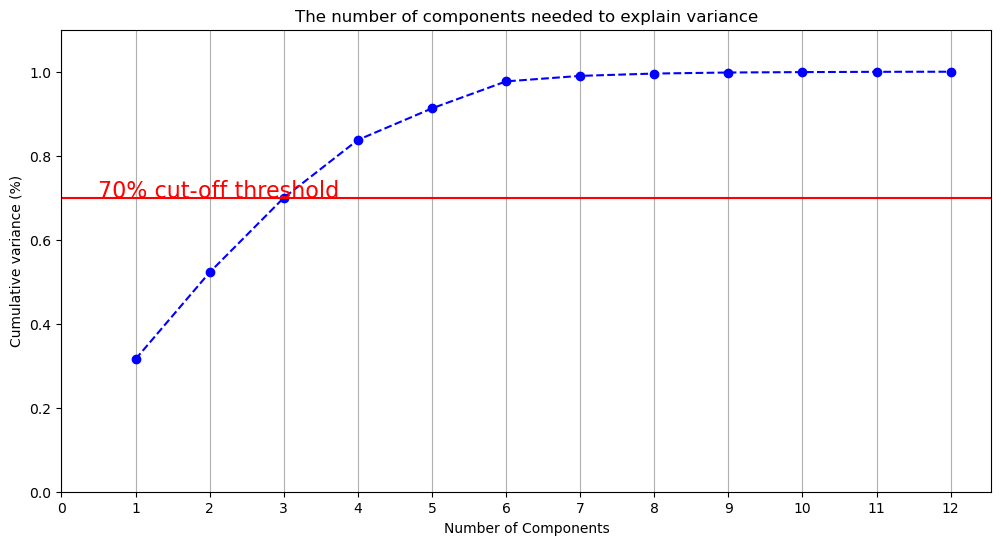

In [ ]:
# Import the PCA (Principal Component Analysis) library from scikit-learn
pca = PCA().fit(dataset_norm)

# Set the dimensions of the figure
plt.rcParams["figure.figsize"] = (12, 6)

# Create a new plot
fig, ax = plt.subplots()

# Create the curve of cumulative variance as a function of the number of components
xi = np.arange(1, 13, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

# Set the axes and curve style
plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

# Label the axes and title of the graph
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 13, step=1))  # Change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

# Add a red horizontal line at 70% cumulative variance
plt.axhline(y=0.70, color='r', linestyle='-')
plt.text(0.5, 0.70, '70% cut-off threshold', color='red', fontsize=16)

# Add grids on the x-axis
ax.grid(axis='x')

# Display the plot
plt.show()


In [ ]:
# Set the desired number of components for PCA
num_components = 3

# Apply PCA with the specified number of components
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(dataset_norm)

# Create a new DataFrame with the results of PCA
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(num_components)])

# Concatenate the new DataFrame with the original DataFrame
result_df = pd.concat([dataset_norm[['avg_click_duration', 'avg_time_spend_day', 'most_active_day', 'weekend_movies_count', 'max_duration', 'avg_release_year', 'days_since_last_watch', 'genre_diversity', 'most_active_hour', 'num_genres_watched', 'total_watch_time', 'num_movies_watched']], pca_df], axis=1)

# Display the resulting DataFrame
result_df


,avg_click_duration,avg_time_spend_day,most_active_day,weekend_movies_count,max_duration,avg_release_year,days_since_last_watch,genre_diversity,most_active_hour,num_genres_watched,total_watch_time,num_movies_watched,PC1,PC2,PC3
0,3.985701e-07,3.985701e-07,1.000000,0.000000,3.985701e-07,0.974790,0.631463,0.095238,0.739130,0.08,2.810774e-07,0.000000,-0.476079,0.165227,-0.209832
1,4.201198e-02,5.601584e-02,0.333333,0.000000,1.675684e-01,0.933824,0.105611,0.190476,0.489130,0.20,1.185090e-01,0.042857,0.147767,-0.328814,0.128620
2,5.953760e-02,5.953760e-02,0.666667,0.000000,5.953760e-02,0.924370,0.048405,0.047619,0.739130,0.04,4.198678e-02,0.000000,-0.183167,-0.421334,-0.141637
3,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.962185,0.046205,0.142857,0.217391,0.12,0.000000e+00,0.000000,0.473157,-0.434339,0.067467
4,1.015357e-03,2.030316e-03,0.666667,0.000000,2.030316e-03,0.962185,0.156216,0.047619,0.934783,0.04,1.431808e-03,0.014286,-0.173836,-0.335219,-0.199273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.985701e-07,3.985701e-07,0.166667,0.000000,3.985701e-07,0.936975,0.052805,0.142857,0.304348,0.12,2.810774e-07,0.014286,0.308920,-0.417565,0.045426
996,1.076139e-05,2.112421e-05,0.833333,0.022222,2.152278e-05,0.918067,0.964796,0.190476,0.000000,0.16,1.489710e-05,0.014286,-0.296976,0.538689,-0.034948
997,3.985701e-07,3.985701e-07,0.333333,0.000000,3.985701e-07,0.949580,0.612761,0.142857,0.739130,0.12,2.810774e-07,0.000000,0.186690,0.116346,-0.135066
998,3.985701e-07,3.985701e-07,1.000000,0.000000,3.985701e-07,0.936975,0.169417,0.142857,1.000000,0.12,2.810774e-07,0.000000,-0.505085,-0.281172,-0.122274


2.3

# Q2.3 Clustering!

total_df is a dataframe which includes our features and our columns 'PC1', 'PC2', 'PC3'.

These last 3 columns are the result of the Principal Component Analysis (*PCA*).

We used them to perform the k-means according to the dimensionality reduction.

df_clustering is a dataframe which just contains the PCA columns.

In [ ]:
df_clustering = total_df[['PC1','PC2','PC3']]

In [ ]:
# An overview
df_clustering.head(10)

,PC1,PC2,PC3
0,-0.476079,0.165227,-0.209832
1,0.147767,-0.328814,0.128620
2,-0.183167,-0.421334,-0.141637
3,0.473157,-0.434339,0.067467
4,-0.173836,-0.335219,-0.199273
5,-0.162785,-0.108176,-0.064641
6,0.493100,-0.201670,0.114294
7,-0.135963,0.279710,-0.081772
8,-0.336148,-0.025972,0.193660
9,-0.353997,-0.368719,0.022132


In [ ]:
# An overview
total_df.head(10)

,avg_click_duration,avg_time_spend_day,most_active_day,weekend_movies_count,max_duration,avg_release_year,days_since_last_watch,genre_diversity,most_active_hour,num_genres_watched,total_watch_time,num_movies_watched,PC1,PC2,PC3
0,3.985701e-07,3.985701e-07,1.000000,0.000000,3.985701e-07,0.974790,0.631463,0.095238,0.739130,0.08,2.810774e-07,0.000000,-0.476079,0.165227,-0.209832
1,4.201198e-02,5.601584e-02,0.333333,0.000000,1.675684e-01,0.933824,0.105611,0.190476,0.489130,0.20,1.185090e-01,0.042857,0.147767,-0.328814,0.128620
2,5.953760e-02,5.953760e-02,0.666667,0.000000,5.953760e-02,0.924370,0.048405,0.047619,0.739130,0.04,4.198678e-02,0.000000,-0.183167,-0.421334,-0.141637
3,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.962185,0.046205,0.142857,0.217391,0.12,0.000000e+00,0.000000,0.473157,-0.434339,0.067467
4,1.015357e-03,2.030316e-03,0.666667,0.000000,2.030316e-03,0.962185,0.156216,0.047619,0.934783,0.04,1.431808e-03,0.014286,-0.173836,-0.335219,-0.199273
5,3.985701e-07,3.985701e-07,0.666667,0.000000,3.985701e-07,0.911765,0.348735,0.190476,0.826087,0.16,2.810774e-07,0.000000,-0.162785,-0.108176,-0.064641
6,7.224083e-04,1.444418e-03,0.000000,0.000000,2.888437e-03,0.924370,0.268427,0.285714,0.706522,0.24,2.036968e-03,0.042857,0.493100,-0.201670,0.114294
7,3.985701e-07,3.985701e-07,0.666667,0.000000,3.985701e-07,0.924370,0.739274,0.238095,0.869565,0.20,2.810774e-07,0.014286,-0.135963,0.279710,-0.081772
8,6.840180e-03,1.709985e-02,0.833333,0.066667,3.075606e-02,0.969748,0.370737,0.285714,0.582609,0.36,2.411785e-02,0.057143,-0.336148,-0.025972,0.193660
9,9.353045e-03,1.870569e-02,0.833333,0.022222,1.870569e-02,0.905462,0.055006,0.142857,0.478261,0.16,1.319152e-02,0.014286,-0.353997,-0.368719,0.022132


**K-Means Idea:**

Let X = {x1, ..., xn} be a set of n datapoints, each with dimension d.

The k-means problem seeks to find a set of k means M = {µ1, ..., µk} which minimizes the distances between each data point of each cluster.

In other words, we wish to choose k means so as to minimize the sum of the squared distances between each point in the dataset and the mean closest to that point.

## 2.3.1
### Implementation of the K-means clustering algorithm (not ++: random initialization) using MapReduce

#### Steps:

1. Choose k initial means (µ_1, ..., µ_k) uniformly at random from the set X.

2. For each point x in X, find the closest mean mu_i and add x to a set S_i.

3. For i = 1, ..., k, set µ_i to be the centroid of the points in S_i.

4. Repeat steps 2 and 3 until the means have converged.


**MapReduce:**

Each iteration of standard k-means can be divided into two phases:
1. The first phase (**map**) computes the sets S_i of points closest to mean µ_i.
2. The second phase (**reduce**) computes new means as the centroids of these sets.

These two phases correspond to the Map and Reduce phases of our MapReduce algorithm.


#### Compute random centroids:
- Given a number k of clusters and a dataframe, this function returns a new dataframe  where the columns are random centroids.

In [ ]:
def random_centroids(df,k):

    # Initialize a list of k centroids
    centroids = []

    for i in range(k):

        # Random centroid using sample method
        centroid = df.apply(lambda x: float(x.sample()))

        # Append the centroid to our list of centroids
        centroids.append(centroid)

    return pd.concat(centroids, axis=1)

**Compute euclidean distances and find the minimum:**
- Given a dataframe and random centroids, this function returns the cluster closest to the user.

1. Distances is a dataframe where each row rapresents the distance between the user and the cluster.
2. We are going to extract the cluster corresponding to the minimum distance value.

In [ ]:
def get_labels(df, centroids):

    # Compute the euclidean distances
    distances = centroids.apply(lambda x: np.sqrt(((df - x) ** 2).sum(axis=1)))

    # Find and return the cluster corresponding to the minimum distance for each row
    closest_cluster = distances.idxmin(axis=1)

    return closest_cluster

**Update centroids and compute the mean:**
- In this step we group by labels and we update the centroid using mean method.

Same labels corresponds to data points in the same cluster.

In [ ]:
def new_centroids(df,labels):

    # Group by labels
    grouped_df = df.groupby(labels)

    # Compute the mean for each cluster to update the centroid
    new_centroids = grouped_df.mean().T

    return new_centroids

**Kmeans function:**
- Given a dataframe and a number k of clusters, the while loop ends when iteration = 100 or the current centroid is equal to the previous (convergence).

This function allows us to recognize clusters. Each user is related to a cluster. The final labels are returned.

In [ ]:
def my_Kmeans(df, k):
    # Set the maximum number of iterations
    max_iteration = 100

    # Initialize the iteration counter
    iteration = 1

    # Create an empty DataFrame to store the old centroids
    old_centroids = pd.DataFrame()

    # Initialize centroids using the random_centroids function
    centroids = random_centroids(df, k)

    # Continue iterating until the maximum number of iterations is reached or centroids converge
    while iteration < max_iteration and not centroids.equals(old_centroids):
        # Update the old centroids with the current centroids
        old_centroids = centroids

        # Assign data points to clusters based on the current centroids
        labels = get_labels(df, centroids)

        # Compute new centroids based on the assigned clusters
        centroids = new_centroids(df, labels)

        # Increment the iteration counter
        iteration += 1

    # Return the final cluster labels
    return labels

## 2.3.2

### Find the optimal number of clusters.

The following code is an approach to determine the optimal number of clusters (k) in a K-means clustering algorithm using the concept of "inertia".

The idea is to observe how the inertia changes for different values of k and choose a value where the decrease in inertia begins to slow down (the "elbow" of the plot).

In [ ]:
# Initialize a dictionary to store our values
inertia = {}

#Iterate over k to find the optimal number of clusters
for k in range(1, 20):

    # To retrieve the sum of squared distances of samples to their closest cluster center
    model=KMeans(n_clusters=k)
    model.fit(df_clustering)
    inertia[k] = model.inertia_

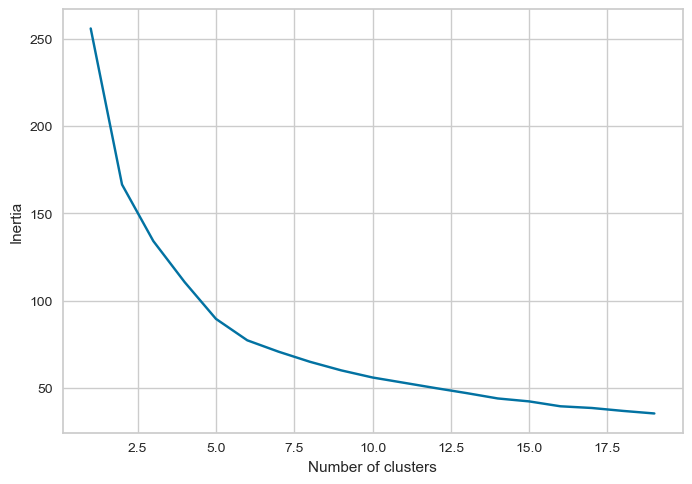

In [ ]:
# A plot to view the elbow
plt.figure()
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

**Kelbow_visualizer:**

- The kelbow_visualizer is used to visualize the "elbow" in the K-means clustering process. The elbow method is performed to determine the optimal number of clusters by considering the rate of decrease of distortion (inertia) as the number of clusters increases.

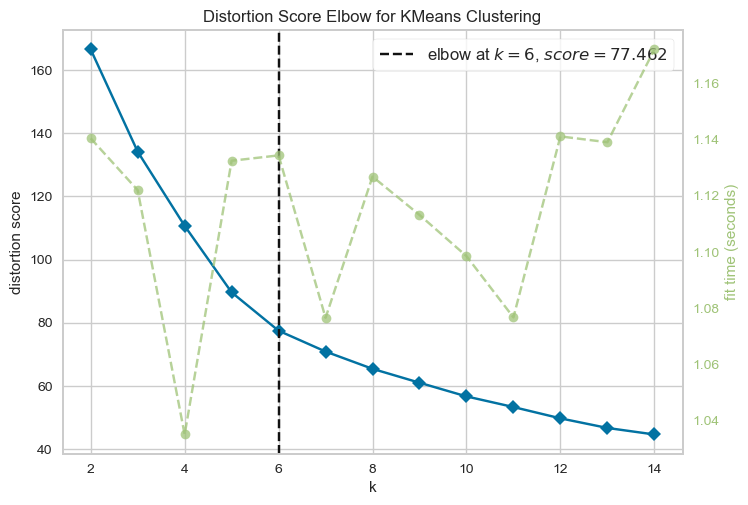

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=14), k=(2, 15))

In [ ]:


kelbow_visualizer(KMeans(), df_clustering, k=(2,15))

**Visualization Output:**

- The visualizer produces a plot showing the distortion score (inertia) for different values of k. It marks the "elbow" point. The "elbow" is the point where increasing the number of clusters ceases and there is a significant reduction in inertia. The idea is to choose a value of k at the elbow, as it represents a good trade-off between complexity and performance. This visualization is useful for determining a suitable value for the number of clusters in the absence of a clear and distinct elbow in the inertia plot.

For this reason we choose k =6.

**Kelbow visualizer using silhouette metric:**

- The kelbow_visualizer is used to visualize the elbow method for K-means clustering, specifically using the silhouette score as the metric.

- 'metric='silhouette' specifies that the silhouette score should be used to evaluate the quality of clustering for different values of k.

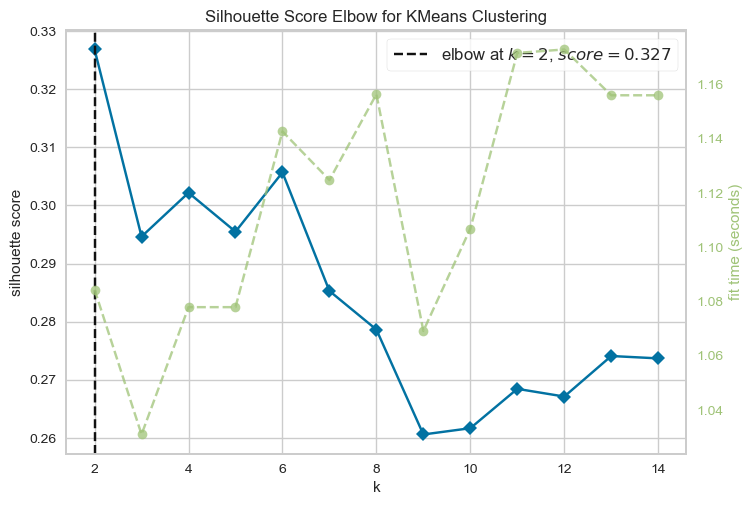

KElbowVisualizer(ax=<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=14), k=(2, 15),
                 metric='silhouette')

In [ ]:
kelbow_visualizer(KMeans(),df_clustering, k=(2,15), metric='silhouette')

**Visualization Output:**

- The visualizer produces a plot showing the silhouette score for different values of k. The silhouette score measures how similar an object is to its own cluster compared to other clusters. We can choose the value of k that maximizes the silhouette score, indicating better-defined clusters.

The silhouette score is a measure of cluster of cohesion and separation but a consistent and very relevant decrease in the number of clusters.

**Intercluster distances for K-means clustering:**

In [ ]:
# Using the optimal number of clusters
model=KMeans(n_clusters=6)

# Fit the model
model.fit(df_clustering)

# Predict cluster labels for each data point
values = model.predict(df_clustering)

InterclusterDistance(ax=<Axes: >, estimator=KMeans(n_clusters=6))

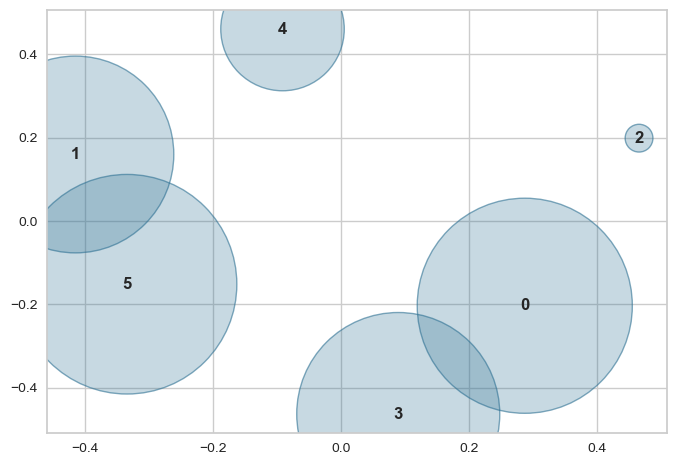

In [ ]:
# Create an InterclusterDistance visualizer
viz = InterclusterDistance(model)
viz.fit(values)

- The InterclusterDistance visualizer is useful for understanding the distribution of distances between cluster centers, providing insights into how distinct the clusters are from each other.

## 2.3

### Run the algorithm on the data obtained from the dimensionality reduction.

- We found that k = 6 clusters is the optimal number.

In the following code we performed the kmeans algorithm. Then we added a column 'cluster' to our dataframe to map each user to a cluster.

In [ ]:
df_kmeans = df_clustering.copy()

# To store the labels for each user
final_groups = my_Kmeans(df_kmeans,6)
df_kmeans['cluster'] = final_groups

In [ ]:
# An overview
df_kmeans.head(10)

,PC1,PC2,PC3,cluster
0,-0.476079,0.165227,-0.209832,1
1,0.147767,-0.328814,0.128620,2
2,-0.183167,-0.421334,-0.141637,5
3,0.473157,-0.434339,0.067467,2
4,-0.173836,-0.335219,-0.199273,5
5,-0.162785,-0.108176,-0.064641,5
6,0.493100,-0.201670,0.114294,2
7,-0.135963,0.279710,-0.081772,1
8,-0.336148,-0.025972,0.193660,3
9,-0.353997,-0.368719,0.022132,5


We plotted them to have a look on our clusters.

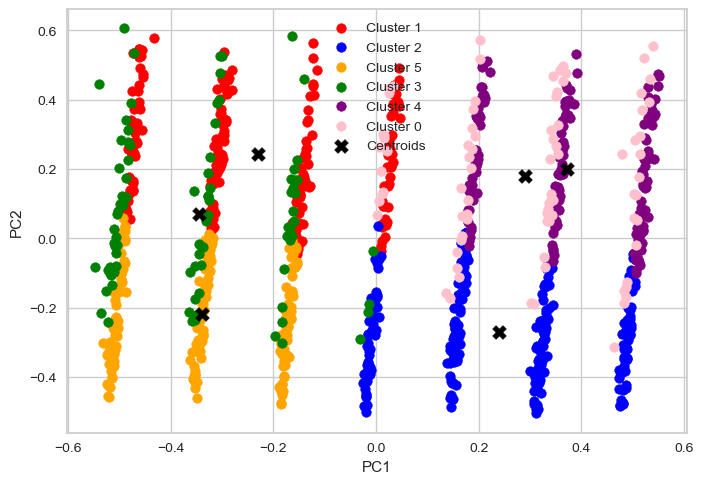

In [ ]:
# Setting color values for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']

# Plot data
for cluster_id in df_kmeans['cluster'].unique():
    cluster_data = df_kmeans[df_kmeans['cluster'] == cluster_id]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], c=colors[cluster_id - 1], label=f'Cluster {cluster_id}')

# Plot centroids
centroids = df_kmeans.groupby('cluster')['PC1', 'PC2'].mean()
plt.scatter(centroids['PC1'], centroids['PC2'], c='black', marker='X', s=100, label='Centroids')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## 2.3.4

### Implementation of K-means++ from scratch.

- This function implements the **k-means++** initialization method, which aims to improve the convergence of the k-means algorithm by smartly selecting initial centroids. The algorithm iteratively selects centroids, ensuring that each new centroid is far from existing centroids.

In [ ]:
def kmeans_plusplus_init(df, k):
    # Randomly choose the first centroid
    centroids = [df.iloc[np.random.choice(len(df))].values]

    # Iterate to choose the next centroids
    for _ in range(1, k):
        # Compute squared distances from each data point to the nearest existing centroid
        distances = np.array([min(np.linalg.norm(np.array(point) - np.array(c))**2 for c in centroids) for point in df.values])

        # Choose the next centroid with probability proportional to squared distance
        probabilities = distances / distances.sum()
        next_centroid_index = np.random.choice(len(df), p=probabilities)

        # Append the coordinates of the next centroid to the list
        centroids.append(df.iloc[next_centroid_index].values)

    # Convert the list of centroids to a DataFrame and transpose it
    return pd.DataFrame(centroids, columns=df.columns).T

- This function represents the k-means++ algorithm, where centroids are initialized using the kmeans++ method, and the algorithm iteratively assigns labels and updates centroids until convergence or reaching the maximum number of iterations. The final labels are returned.

In [ ]:
def my_Kmeans_pp(df, k):
    # Set maximum number of iterations
    max_iteration = 100

    # Initialize iteration counter
    iteration = 1

    # Initialize DataFrame to store previous centroids
    old_centroids = pd.DataFrame()

    # Initialize centroids using kmeans++ method
    centroids = kmeans_plusplus_init(df, k)

    # Continue iterations until convergence or reaching maximum iterations
    while iteration < max_iteration and not centroids.equals(old_centroids):
        # Update old centroids
        old_centroids = centroids

        # Assign labels to data points based on current centroids
        labels = get_labels(df, centroids)

        # Update centroids based on assigned labels
        centroids = new_centroids(df, labels)

        # Increment iteration counter
        iteration += 1

    # Return the final labels
    return labels

In [ ]:
df_kmeans_pp = df_clustering.copy()
final_groups_pp = my_Kmeans_pp(df_kmeans_pp,6)
df_kmeans_pp['cluster_pp'] = final_groups_pp

In [ ]:
df_kmeans_pp.head(10)

,PC1,PC2,PC3,cluster_pp
0,-0.476079,0.165227,-0.209832,3
1,0.147767,-0.328814,0.128620,1
2,-0.183167,-0.421334,-0.141637,0
3,0.473157,-0.434339,0.067467,1
4,-0.173836,-0.335219,-0.199273,0
5,-0.162785,-0.108176,-0.064641,0
6,0.493100,-0.201670,0.114294,1
7,-0.135963,0.279710,-0.081772,4
8,-0.336148,-0.025972,0.193660,0
9,-0.353997,-0.368719,0.022132,0


We plotted them to have a look on our clusters.

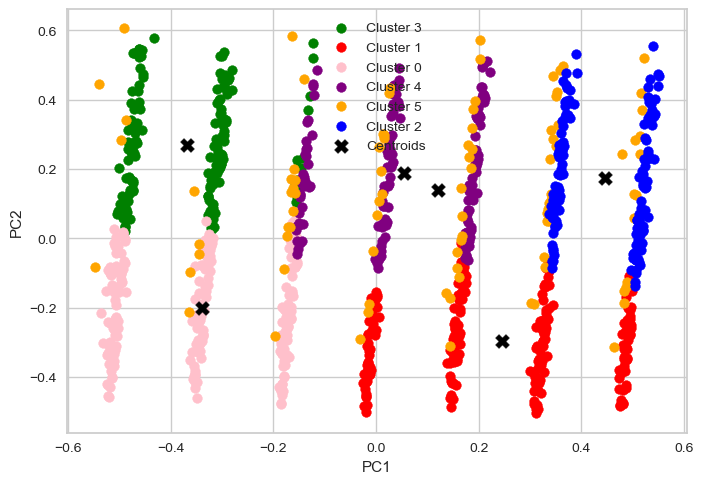

In [ ]:
# Setting color values for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']

# Plot data
for cluster_id_pp in df_kmeans_pp['cluster_pp'].unique():
    cluster_data_pp = df_kmeans_pp[df_kmeans_pp['cluster_pp'] == cluster_id_pp]
    plt.scatter(cluster_data_pp['PC1'], cluster_data_pp['PC2'], c=colors[cluster_id_pp - 1], label=f'Cluster {cluster_id_pp}')

# Plot centroids
centroids_pp = df_kmeans_pp.groupby('cluster_pp')['PC1', 'PC2'].mean()
plt.scatter(centroids_pp['PC1'], centroids_pp['PC2'], c='black', marker='X', s=100, label='Centroids')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

The clusters are well separated except for the cluster 5.

The centroids are far from each others.

We improved the clusters separation compared to the k-means plot.

## 2.3.5

### Ask ChatGPT to recommend other clustering algorithms and choose one.

**Agglomerative clustering:**

In [ ]:

agg_clustering = AgglomerativeClustering(n_clusters=6)
labels = agg_clustering.fit_predict(df_clustering)

- Agglomerative clustering is less sensitive to initializations, so it can provide better starting points for k-means to converge to a good solution.

In [ ]:
df_agglomerative_clust = df_clustering.copy()
df_agglomerative_clust['cluster'] = labels

In [ ]:
df_agglomerative_clust.head(10)

,PC1,PC2,PC3,cluster
0,-0.476079,0.165227,-0.209832,0
1,0.147767,-0.328814,0.128620,4
2,-0.183167,-0.421334,-0.141637,0
3,0.473157,-0.434339,0.067467,4
4,-0.173836,-0.335219,-0.199273,0
5,-0.162785,-0.108176,-0.064641,2
6,0.493100,-0.201670,0.114294,4
7,-0.135963,0.279710,-0.081772,2
8,-0.336148,-0.025972,0.193660,0
9,-0.353997,-0.368719,0.022132,0


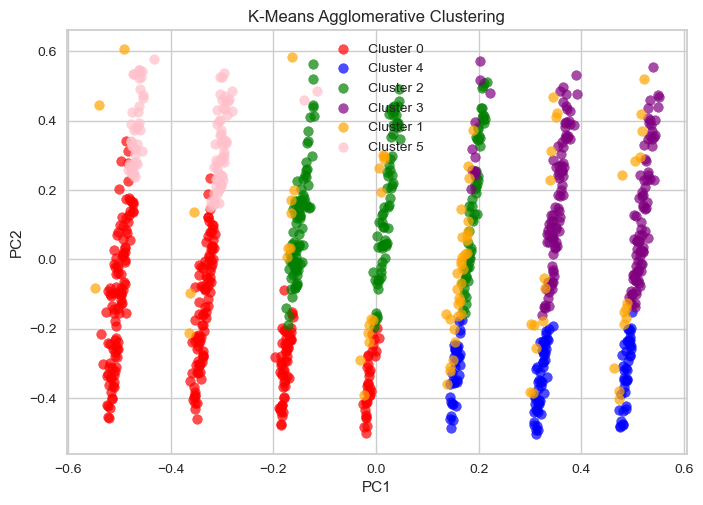

In [ ]:
# Assuming 'df_clustering' is a DataFrame with 'cluster' column
custom_colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']

# Scatter plot with custom colors
for cluster_id, color in zip(df_agglomerative_clust['cluster'].unique(), custom_colors):
    cluster = df_agglomerative_clust[df_agglomerative_clust['cluster'] == cluster_id]
    plt.scatter(cluster['PC1'], cluster['PC2'], color=color, label=f'Cluster {cluster_id}', alpha=0.7)

plt.title('K-Means Agglomerative Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

- From this plot we can say that the separation of the clusters is similar to the k-means++ plot but there is a reduction in the number of outliers.

# Q2.4 Analysing your results!

## 2.4.1

### Select 2-3 relevant variables to identify the cluster of the customer.

1) **genre_diversity**: Customers with diverse genre preferences may have different viewing habits and preferences. It can capture the breadth of a customer's interests.
2) **days_since_last_watch**: Recency of a customer's engagement. Customers who recently watched content might have different preferences or behaviors compared to those who haven't watched in a while.
3) **total_watch_time**: Reflects the overall engagement level. Customers with high total watch time may have different preferences compared to those with lower watch time. It captures the intensity of a customer's interaction with the platform.

These three variables cover different aspects of customer engagement.

In [ ]:
new_df = total_df[['genre_diversity','days_since_last_watch','total_watch_time']]

In [ ]:
new_df

,genre_diversity,days_since_last_watch,total_watch_time
0,0.095238,0.631463,2.810774e-07
1,0.190476,0.105611,1.185090e-01
2,0.047619,0.048405,4.198678e-02
3,0.142857,0.046205,0.000000e+00
4,0.047619,0.156216,1.431808e-03
...,...,...,...
995,0.142857,0.052805,2.810774e-07
996,0.190476,0.964796,1.489710e-05
997,0.142857,0.612761,2.810774e-07
998,0.142857,0.169417,2.810774e-07


## 2.4.2

### Categorize them into four categories.

### **Genre Diversity:**
- **Low:**
  - **Description:** Customers with a narrow range of genre preferences.
  - **Criteria:** Values below the 25th percentile.

- **Moderate-Low:**
  - **Description:** Customers with a moderate but not extensive variety of genre preferences.
  - **Criteria:** Values between the 25th and 50th percentiles.

- **Moderate-High:**
  - **Description:** Customers with a broad range of genre preferences.
  - **Criteria:** Values between the 50th and 75th percentiles.

- **High:**
  - **Description:** Customers with an extensive variety of genre preferences.
  - **Criteria:** Values above the 75th percentile.

### **Days Since Last Watch:**
- **Low:**
  - **Description:** Customers who recently watched content.
  - **Criteria:** Values below the 25th percentile.

- **Moderate-Low:**
  - **Description:** Customers with moderate recency of engagement.
  - **Criteria:** Values between the 25th and 50th percentiles.

- **Moderate-High:**
  - **Description:** Customers with a relatively longer gap since their last watch.
  - **Criteria:** Values between the 50th and 75th percentiles.

- **High:**
  - **Description:** Customers with a significant gap since their last watch.
  - **Criteria:** Values above the 75th percentile.

### **Total Watch Time:**
- **Low:**
  - **Description:** Customers with a low total watch time.
  - **Criteria:** Values below the 25th percentile.

- **Moderate-Low:**
  - **Description:** Customers with a moderate total watch time.
  - **Criteria:** Values between the 25th and 50th percentiles.

- **Moderate-High:**
  - **Description:** Customers with a relatively higher total watch time.
  - **Criteria:** Values between the 50th and 75th percentiles.

- **High:**
  - **Description:** Customers with a high total watch time.
  - **Criteria:** Values above the 75th percentile.

## 2.4.3 / 2.4.4

**With the selected variables, perform pivot tables. Calculate the percentage by column for each pivot table.**

In [ ]:
# Agglomerative clustering
model = AgglomerativeClustering(n_clusters=6)
new_df['cluster'] = model.fit_predict(new_df)

In [ ]:
# Define categories
categories = {
    'Low': 25,
    'Moderate-Low': 50,
    'Moderate-High': 75,
    'High': 100
}

# Loop through each variable
for variable in ['genre_diversity', 'days_since_last_watch', 'total_watch_time']:
    # Create a new column with categorical values based on percentiles
    new_df[f'{variable}_category'] = pd.cut(new_df[variable], bins=[0] + list(np.percentile(new_df[variable], list(categories.values()))), labels=categories.keys(), include_lowest=True)

    # Create a pivot table with normalized probabilities
    pivot_table = pd.pivot_table(new_df, values=variable, index='cluster', columns=f'{variable}_category', aggfunc='size', fill_value=0)

    # Normalize each row to represent probabilities
    pivot_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

    # Display the pivot table
    print(f"Pivot Table for {variable}\n")
    print(pivot_table)
    print("\n")

Pivot Table for genre_diversity

genre_diversity_category        Low  Moderate-Low  Moderate-High        High
cluster                                                                     
0                         46.685879     21.902017      27.377522    4.034582
1                          0.000000      0.000000      23.728814   76.271186
2                         31.223629     14.767932      34.599156   19.409283
3                         53.051643     21.126761      25.821596    0.000000
4                          0.000000      0.000000       0.000000  100.000000
5                         14.285714      7.142857       0.000000   78.571429


Pivot Table for days_since_last_watch

days_since_last_watch_category        Low  Moderate-Low  Moderate-High  \
cluster                                                                  
0                               61.383285     38.040346       0.576369   
1                                0.000000      0.847458      36.440678   
2             

## 2.4.5

**Interpret the results for each pivot table.**

### Cluster 0:

**Genre Diversity:**
- Low: 46.69%
- Moderate-Low: 21.90%
- Moderate-High: 27.38%
- High: 4.03%

**Days Since Last Watch:**
- Low: 61.38%
- Moderate-Low: 38.04%
- Moderate-High: 0.58%
- High: 0.00%

**Total Watch Time:**
- Low: 40.92%
- Moderate-Low: 23.63%
- Moderate-High: 17.00%
- High: 18.44%

Cluster 0 appears to consist of customers with moderate to high genre diversity, recently watched content, and moderate total watch time.

### Cluster 1:

**Genre Diversity:**
- Low: 0.00%
- Moderate-Low: 0.00%
- Moderate-High: 23.73%
- High: 76.27%

**Days Since Last Watch:**
- Low: 0.00%
- Moderate-Low: 0.85%
- Moderate-High: 36.44%
- High: 62.71%

**Total Watch Time:**
- Low: 7.63%
- Moderate-Low: 13.56%
- Moderate-High: 29.66%
- High: 49.15%

Cluster 1 represents customers with high genre diversity, a moderate gap since the last watch, and a balanced distribution of total watch time.

### Cluster 2:

**Genre Diversity:**
- Low: 31.22%
- Moderate-Low: 14.77%
- Moderate-High: 34.60%
- High: 19.41%

**Days Since Last Watch:**
- Low: 0.00%
- Moderate-Low: 36.29%
- Moderate-High: 63.71%
- High: 0.00%

**Total Watch Time:**
- Low: 30.80%
- Moderate-Low: 17.72%
- Moderate-High: 30.38%
- High: 21.10%

Cluster 2 comprises customers with diverse genre preferences, a relatively longer gap since the last watch, and a balanced total watch time.

### Cluster 3:

**Genre Diversity:**
- Low: 53.05%
- Moderate-Low: 21.13%
- Moderate-High: 25.82%
- High: 0.00%

**Days Since Last Watch:**
- Low: 0.00%
- Moderate-Low: 0.00%
- Moderate-High: 20.66%
- High: 79.34%

**Total Watch Time:**
- Low: 35.68%
- Moderate-Low: 22.54%
- Moderate-High: 26.76%
- High: 15.02%

Cluster 3 consists of customers with moderate genre diversity, a significant gap since the last watch, and a balanced total watch time.

### Cluster 4:

**Genre Diversity:**
- Low: 0.00%
- Moderate-Low: 0.00%
- Moderate-High: 0.00%
- High: 100.00%

**Days Since Last Watch:**
- Low: 52.11%
- Moderate-Low: 46.48%
- Moderate-High: 1.41%
- High: 0.00%

**Total Watch Time:**
- Low: 7.04%
- Moderate-Low: 9.86%
- Moderate-High: 38.03%
- High: 45.07%

Cluster 4 represents customers with high genre diversity, recently watched content, and a balanced total watch time.

### Cluster 5:

**Genre Diversity:**
- Low: 14.29%
- Moderate-Low: 7.14%
- Moderate-High: 0.00%
- High: 78.57%

**Days Since Last Watch:**
- Low: 0.00%
- Moderate-Low: 0.00%
- Moderate-High: 50.00%
- High: 50.00%

**Total Watch Time:**
- Low: 0.00%
- Moderate-Low: 0.00%
- Moderate-High: 0.00%
- High: 100.00%

Cluster 5 consists of customers with high genre diversity, a balanced distribution of recency, and high total watch time.

## 2.4.6

**Use any known metrics to estimate clustering algorithm performance.**

For this purpose we used **Silhouette metric.**

The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

The silhouette score ranges from -1 to 1, where:

- A score near 1 suggests that the object is well matched to its own cluster and poorly matched to neighboring clusters, indicating a good separation.
- A score around 0 indicates overlapping clusters, and the data points could be in the border between two clusters.

In [ ]:

silhouette_avg = silhouette_score(new_df[['genre_diversity', 'days_since_last_watch', 'total_watch_time']], new_df['cluster'])

In [ ]:
silhouette_avg

0.33820642243313864

**Result:**

- A score of 0.34 suggests that the clusters are reasonably well-defined and that the objects within each cluster are more similar to each other than they are to objects in other clusters. It indicates a moderate level of separation between clusters.

## Q3. BONUS

**Ask ChatGPT (or any other LLM tool) to list three algorithms for Density-Based Clustering. Choose one and use it on the same dataset you used in 2.3. Analyze your results.**

In [ ]:
# Using DBSCAN with eps

df_dbscan = df_clustering.copy()

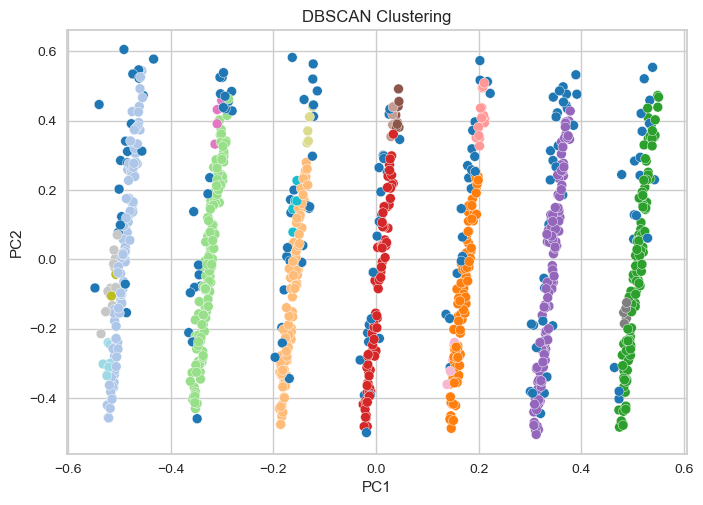

In [ ]:
# Initialize the model
dbscan = DBSCAN(eps=0.1, min_samples=5)  # Adjust the eps value

# Fit the model
labels = dbscan.fit_predict(df_dbscan[['PC1', 'PC2', 'PC3']])

# Add the cluster labels to your original dataframe
df_dbscan['dbscan_cluster'] = labels

# Plot the clusters
plt.scatter(df_dbscan['PC1'], df_dbscan['PC2'], c=labels, cmap='tab20', marker='o', edgecolors='w', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

**Results:**

- As we can see, the clusters seem to be well separated except the blue one. It seems that DBSCAN is more flexible in discovering clusters with varying shapes and sizes, it doesn't require specifying the number of clusters in advance and is not influenced by outliers.

**A look to our dataframe:**

In [ ]:
df_dbscan.head(20)

,PC1,PC2,PC3,dbscan_cluster
0,-0.476079,0.165227,-0.209832,0
1,0.147767,-0.328814,0.128620,1
2,-0.183167,-0.421334,-0.141637,2
3,0.473157,-0.434339,0.067467,3
4,-0.173836,-0.335219,-0.199273,2
5,-0.162785,-0.108176,-0.064641,2
6,0.493100,-0.201670,0.114294,3
7,-0.135963,0.279710,-0.081772,2
8,-0.336148,-0.025972,0.193660,4
9,-0.353997,-0.368719,0.022132,4


Another consideration could be that DBSCAN explicitly identifies outliers as points not assigned to any cluster (labeled as -1).

## 5. Algoritmic Question (AQ)
Federico studies in a demanding university where he has to take a certain number N of exams to graduate, but he is free to choose in which order he will take these exams. Federico is panicking since this university is not only one of the toughest in the world but also one of the weirdest. His final grade won't depend at all on the mark he gets in these courses: there's a precise evaluation system.

He was given an initial personal score of S when he enrolled, which changes every time he takes an exam: now comes the crazy part. He soon discovered that every of the N exams he has to take is assigned a mark p. Once he has chosen an exam, his score becomes equal to the mark p, and at the same time, the scoring system changes:

*   If he takes an "easy" exam (the score of the exam being less than his score), every other exam's mark is increased by the quantity S-p
*   If he takes a "hard" exam (the score of the exam is greater than his score), every other exam's mark is decreased by the quantity p-S

So, for example, consider S=8 as the initial personal score. Federico must decide which exam he wants to take, being [5,7,1] the marks list. If he takes the first one, being 5<8 and 8-5=3, the remaining list now becomes [10, 4], and his score is updated as S=5.

In this chaotic university where the only real exam seems to be choosing the best way to take exams, you are the poor student advisor who is facing a long queue of confused people who need some help. Federico is next in line, and he comes up in turn with an inescapable question: he wants to know which is the highest score possible he could get.

In [ ]:
#Take the inputs.
initial_score = int(input())
marks = list(map(int, input().split()))

ValueError: invalid literal for int() with base 10: 'st'

a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.

In [ ]:
# In order to find the maximum score possible, we try every alternative order we can take the exams.
# To do this, we use the permutation function from itertools library and save the results to a list. Then, we consider every
# possible order one by one and see what is the biggest score the student can get.

all_permutations = permutations(marks)

# To be able to save the score we find when we consider a spesific solution, we create an empty list called possible_scores.
possible_scores = list()

# Iterate over all possible ways we can take the exams.
for perm in all_permutations:
  # Since the remaining marks change after each selection, we keep our current marks in a list we update after each selection.
  temp_marks = perm
  # Take the initial score as the current_score.
  current_score = initial_score
  # Iterate all the elements in the temp_marks list.
  for i in range(len(temp_marks)-1):
    # Take the first exam.
    selected_mark = temp_marks[0]
    # Calculate the difference between the exam's score and the current score of Federico.
    a = abs(selected_mark-current_score)
    # Delete the exam we have selected from the list so that we don't take the same exam again.
    temp_marks = temp_marks[1:]
    # Calculate the new exam scores for the remaining marks.
    if (selected_mark<current_score):
      temp_marks = [x + a for x in temp_marks]
    else:
      temp_marks = [x - a for x in temp_marks]
    # Update current_score as the mark of the selected exam.
    current_score = selected_mark
  # After going through all the exams in one of the permutations, save the score.
  # Since all other items in the temp_marks is deleted after being chosen, the last remaining mark in the list will be the final score for that permutation element.
  last_score = temp_marks[0]
  # Save the score into the possible_scores list.
  possible_scores.append(last_score)
# The maximum score Federico can get is the maximum in the possible scores list.
print (max(possible_scores))

11


b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!

In [ ]:
all_permutations = permutations(marks)
possible_scores = list()

for perm in all_permutations:
  temp_marks = perm
  current_score = initial_score
  for i in range(len(temp_marks)-1):
    selected_mark = temp_marks[0]
    a = abs(selected_mark-current_score)
    temp_marks = temp_marks[1:]
    if (selected_mark<current_score):
      temp_marks = [x + a for x in temp_marks]
    else:
      temp_marks = [x - a for x in temp_marks]
    current_score = selected_mark
  last_score = temp_marks[0]
  possible_scores.append(last_score)

print ("Time complexity is dominated by the permutation operation and the nested for loops. So, the time complexity is O(N!*N). Federico is right, the code is slow especially if there are long lists of exams Federico can take.")

Time complexity is dominated by the permutation operation and the nested for loops. So, the time complexity is O(N!*N). Federico is right, the code is slow especially if there are long lists of exams Federico can take.


c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

In [ ]:
# In the following method in order to get rid off the permutations, which increase the time complexity the most, a recursive function is used.
def max_score_calculator(initial_score, marks):
    # To be able to save the score we find when we consider a spesific solution, we create an empty list called possible_scores.
    possible_scores = list()
    # Iterate all the elements in the marks list.
    for i in range(len(marks)):
        # Select the marks one by one in each iteration.
        selected_mark = marks[i]
        # Calculate the difference between the exam's score and the current score of Federico.
        a = abs(selected_mark - initial_score)
        # Delete the mark of the selected exams from the marks list.
        remaining_marks = marks[:i] + marks[i+1:]
        # Update current_score as the mark of the selected exam.
        if selected_mark < initial_score:
            updated_marks = [x + a for x in remaining_marks]
        else:
            updated_marks = [x - a for x in remaining_marks]
        # Append the result to the list of possible_scores while recursively calling the function with the selected_mark and updated_marks.
        possible_scores.append(max_score_calculator(selected_mark, updated_marks))

    # If the possible_scores list is empty, return the initial_score. If not, return the maximum element in the possible_scores list.
    if not possible_scores:
      return initial_score
    else:
      return max(possible_scores)

print (max_score_calculator(initial_score, marks))
print ("Time complexity is dominated by the recursive call inside the for loop. The recursive call will be exacuted N-1 times in the worst case scenario. For loop will be executed N times. \nThus, the time complexity is O(N^2). Although this depends on the length of the marks list, it has improved.")

11
Time complexity is dominated by the recursive call inside the for loop. The recursive call will be exacuted N-1 times in the worst case scenario. For loop will be executed N times. 
Thus, the time complexity is O(N^2). Although this depends on the length of the marks list, it has improved.


d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

In [ ]:
# I provided ChatGPT 3.5 the code I wrote in the c) part and told it to "write an improved version of the following code, especially focusing on improving the time complexity".
# After it provided the code, I asked it to comment on every line. Here is the resulting code:

# Define a function 'max_score_calculator' that takes initial_score and marks as parameters
def max_score_calculator(initial_score, marks):
    # Define an inner function 'calculate_max_score' that takes current_score and remaining_marks as parameters
    def calculate_max_score(current_score, remaining_marks):
        # If there are no remaining marks, return the current_score
        if not remaining_marks:
            return current_score

        # Initialize a variable to keep track of the maximum possible score
        max_possible_score = float('-inf')

        # Iterate through each mark in the remaining_marks list
        for i in range(len(remaining_marks)):
            # Get the mark at the current index
            selected_mark = remaining_marks[i]
            # Calculate the absolute difference between the selected_mark and the current_score
            a = abs(selected_mark - current_score)
            # Create a new list excluding the current mark from the remaining_marks
            updated_marks = remaining_marks[:i] + remaining_marks[i+1:]

            # Update the updated_marks list based on the comparison between selected_mark and current_score
            if selected_mark < current_score:
                # Adjust each mark in updated_marks by adding the absolute difference
                updated_marks = [x + a for x in updated_marks]
                # Recursively call the function with the updated score and marks
                score = calculate_max_score(selected_mark, updated_marks)
            else:
                # Adjust each mark in updated_marks by subtracting the absolute difference
                updated_marks = [x - a for x in updated_marks]
                # Recursively call the function with the updated score and marks
                score = calculate_max_score(selected_mark, updated_marks)

            # Update the maximum possible score considering the current calculated score
            max_possible_score = max(max_possible_score, score)

        # Return the maximum possible score after iterating through all marks
        return max_possible_score

    # Start the calculation by calling the inner function with initial_score and marks
    return calculate_max_score(initial_score, marks)

# Call the max_score_calculator function with initial_score and marks, then print the result
print(max_score_calculator(initial_score, marks))
print ("The time complexity of this code is again, O(N^2) to the recursion inside the loop and due to the worst-case scenario approach. \n However, this method uses memoization to store the results of intermediate computations. This allows the function to avoid recalculating the same scores multiple times. Thus, this version is more efficient.")

11
The time complexity of this code is again, O(N^2) to the recursion inside the loop and due to the worst-case scenario approach. 
 However, this method uses memoization to store the results of intermediate computations. This allows the function to avoid recalculating the same scores multiple times. Thus, this version is more efficient.


Command Line

For the command line code, oppen command_line_hw4.sh file